## validating image interpolation

In [2]:
from PIL import Image
import os

# Path to the original Zoneplate image
zoneplate_path = '../validation_data/Zoneplate.png'
output_dir = '../validation_data/image_validations'

# Open the grayscale image and convert to RGB
img = Image.open(zoneplate_path).convert('RGB')

# Sizes to test
sizes = [(256, 256), (512, 512), (128, 128)]

# Resize with Lanczos and save
for w, h in sizes:
    resized = img.resize((w, h), resample=Image.LANCZOS)
    out_path = os.path.join(output_dir, f'Zoneplate_{w}x{h}_lanczos_pil.png')
    resized.save(out_path)
    print(f'Saved {out_path}')

# Interpolation modes to test
modes = [
    ("bilinear", Image.BILINEAR),
    ("lanczos", Image.LANCZOS),
    ("nearest", Image.NEAREST),
]

for name, mode in modes:
    resized = img.resize((256, 256), resample=mode)
    out_path = os.path.join(output_dir, f'Zoneplate_256x256_{name}_pil.png')
    resized.save(out_path)
    print(f'Saved {out_path}')

Saved ../validation_data/image_validations/Zoneplate_256x256_lanczos_pil.png
Saved ../validation_data/image_validations/Zoneplate_512x512_lanczos_pil.png
Saved ../validation_data/image_validations/Zoneplate_128x128_lanczos_pil.png
Saved ../validation_data/image_validations/Zoneplate_256x256_bilinear_pil.png
Saved ../validation_data/image_validations/Zoneplate_256x256_lanczos_pil.png
Saved ../validation_data/image_validations/Zoneplate_256x256_nearest_pil.png
Saved ../validation_data/image_validations/Zoneplate_128x128_lanczos_pil.png
Saved ../validation_data/image_validations/Zoneplate_256x256_bilinear_pil.png
Saved ../validation_data/image_validations/Zoneplate_256x256_lanczos_pil.png
Saved ../validation_data/image_validations/Zoneplate_256x256_nearest_pil.png


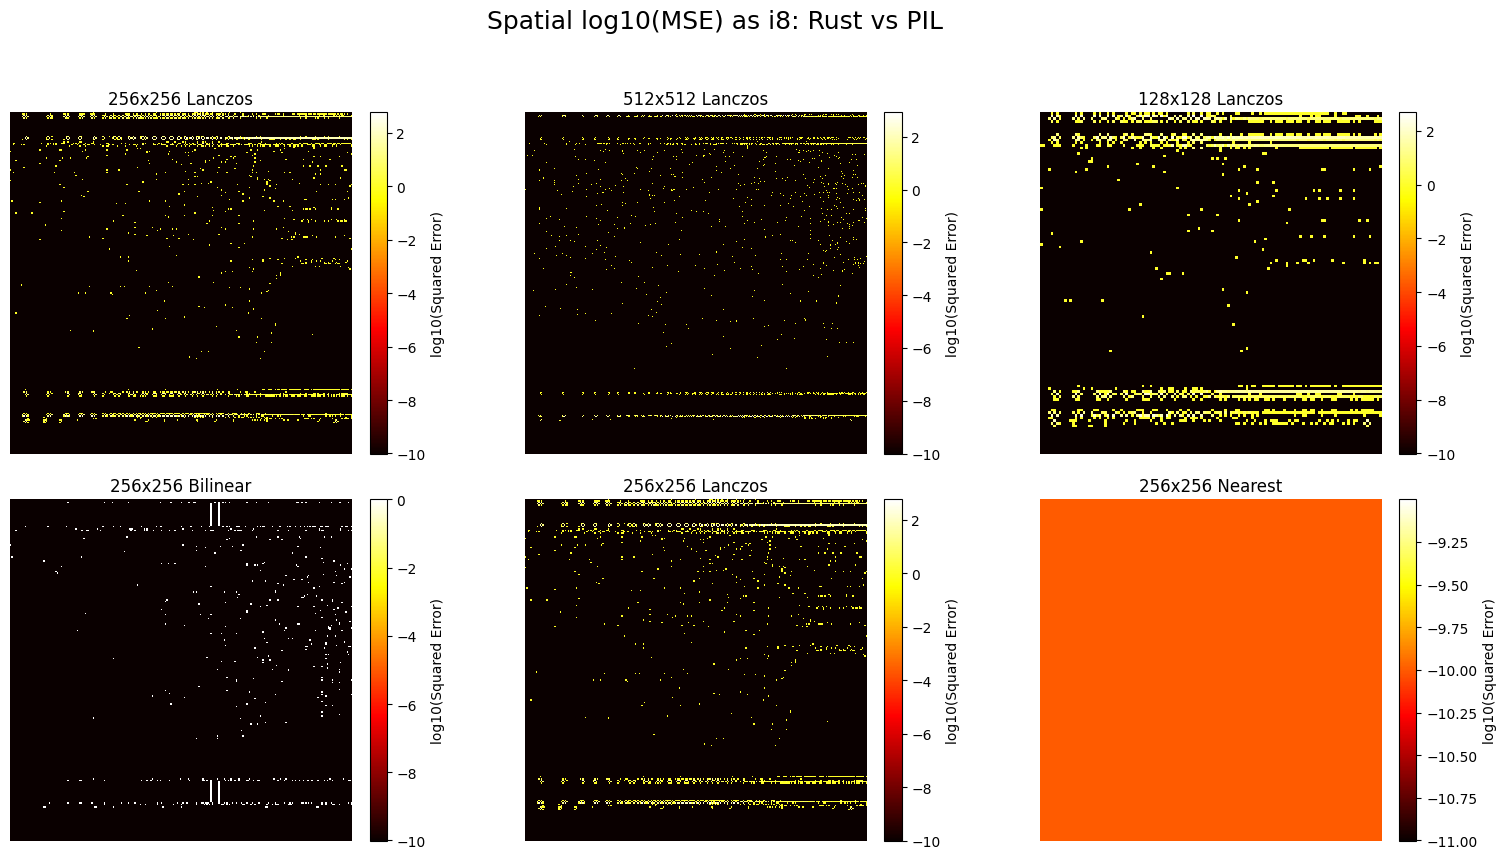

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Directory and base name
output_dir = '../validation_data/image_validations'

# List of sizes and modes to compare
sizes = [(256, 256), (512, 512), (128, 128)]
modes = ["bilinear", "lanczos", "nearest"]

# Helper to compute per-pixel squared error (in log space)
def compute_error_image(img1, img2):
    arr1 = np.asarray(img1).astype(np.float32)
    arr2 = np.asarray(img2).astype(np.float32)
    err = (arr1 - arr2) ** 2
    # If RGB, average over channels for visualization
    if err.ndim == 3:
        err = err.mean(axis=2)
    # Use log10 for visualization, add epsilon to avoid log(0)
    err_log = np.log10(err + 1e-10)
    return err_log

# Collect all error images and titles
err_imgs = []
titles = []

# Size-based comparisons
for w, h in sizes:
    rust_path = os.path.join(output_dir, f'Zoneplate_{w}x{h}_lanczos.png')
    pil_path = os.path.join(output_dir, f'Zoneplate_{w}x{h}_lanczos_pil.png')
    if os.path.exists(rust_path) and os.path.exists(pil_path):
        img_rust = Image.open(rust_path).convert('RGB')
        img_pil = Image.open(pil_path).convert('RGB')
        err_img = compute_error_image(img_rust, img_pil)
        err_imgs.append(err_img)
        titles.append(f'{w}x{h} Lanczos')
    else:
        err_imgs.append(None)
        titles.append(f'{w}x{h} Lanczos (missing)')

# Interpolation mode comparisons (256x256)
for mode in modes:
    rust_path = os.path.join(output_dir, f'Zoneplate_256x256_{mode}.png')
    pil_path = os.path.join(output_dir, f'Zoneplate_256x256_{mode}_pil.png')
    if os.path.exists(rust_path) and os.path.exists(pil_path):
        img_rust = Image.open(rust_path).convert('RGB')
        img_pil = Image.open(pil_path).convert('RGB')
        err_img = compute_error_image(img_rust, img_pil)
        err_imgs.append(err_img)
        titles.append(f'256x256 {mode.capitalize()}')
    else:
        err_imgs.append(None)
        titles.append(f'256x256 {mode.capitalize()} (missing)')

# Plot all error images in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
for idx, ax in enumerate(axes.flat):
    if idx < len(err_imgs) and err_imgs[idx] is not None:
        im = ax.imshow(err_imgs[idx], cmap='hot', interpolation='nearest')
        ax.set_title(titles[idx])
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='log10(Squared Error)')
    else:
        ax.set_title(titles[idx] if idx < len(titles) else '')
        ax.axis('off')
plt.suptitle('Spatial log10(MSE) as i8: Rust vs PIL', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## validating various layers

In [9]:
# Validate patch embedding output for zeros, ones, and random input using SmolVLM weights
import torch
import numpy as np
from transformers import AutoProcessor, AutoModelForVision2Seq


dtype = torch.float32
device = "cpu"

try:
    model = AutoModelForVision2Seq.from_pretrained(
        "HuggingFaceTB/SmolVLM-Instruct",
        # _attn_implementation="flash_attention_2",  # Commented out Flash Attention
        # torch_dtype=torch.bfloat16,
        _attn_implementation="eager",
        torch_dtype=dtype,
        device_map=device,
    )
    model.eval()
except NameError:
    print("Please define or import 'load_smolvlm_model' to load the SmolVLM model.")
    model = None

def zor(layer, shape):
    z = layer(torch.zeros(shape, dtype=dtype, device=device))
    o = layer(torch.ones(shape, dtype=dtype, device=device))
    r = layer(torch.rand(shape, dtype=dtype, device=device))
    return z, o, r

def zor_with_input(layer, zx, ox, rx):
    z = layer(zx)
    o = layer(ox)
    r = layer(rx)
    return z, o, r

patch_embedding = model.model.vision_model.embeddings.patch_embedding
shape = (1, 3, 384, 384)
z, o, r = zor(patch_embedding, shape)
print("Zeros output shape:", z.shape)
print("Ones output shape:", o.shape)
print("Random output shape:", r.shape)

In [10]:
model.model.vision_model.embeddings.patch_embedding